# Fraud Detection System - Data Preprocessing

This notebook handles the preprocessing steps for the transaction data, including:
1. Handling missing values
2. Encoding categorical variables
3. Scaling numerical features
4. Handling class imbalance
5. Feature engineering
6. Train-test split

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import seaborn as sns

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [2]:
# Load the data
df = pd.read_csv('../data/sample_transactions.csv')

# Display basic information
print("Dataset Shape:", df.shape)
print("\nDataset Info:")
df.info()

Dataset Shape: (1000, 10)

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   transaction_id    1000 non-null   int64  
 1   timestamp         1000 non-null   object 
 2   customer_id       1000 non-null   int64  
 3   product_id        1000 non-null   int64  
 4   payment_method    1000 non-null   object 
 5   shipping_address  955 non-null    object 
 6   ip_address        960 non-null    object 
 7   device_id         951 non-null    object 
 8   amount            1000 non-null   float64
 9   is_fraud          1000 non-null   bool   
dtypes: bool(1), float64(1), int64(3), object(5)
memory usage: 71.4+ KB


## 1. Handle Missing Values

Missing Values per Column:
shipping_address    45
ip_address          40
device_id           49
dtype: int64


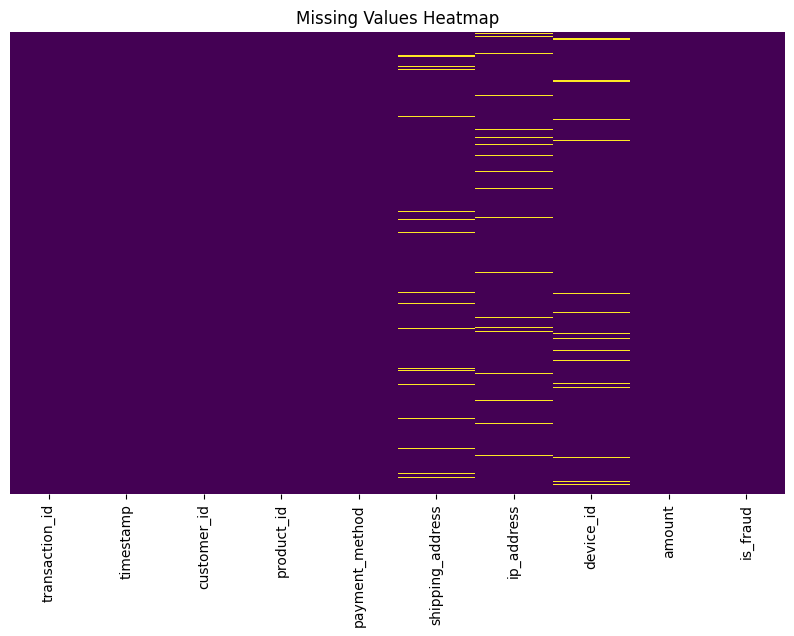

In [3]:
# Check for missing values
missing_values = df.isnull().sum()
print("Missing Values per Column:")
print(missing_values[missing_values > 0])

# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(df.isnull(), yticklabels=False, cbar=False, cmap='viridis')
plt.title('Missing Values Heatmap')
plt.show()

## 2. Feature Engineering

In [4]:
# Convert timestamp to datetime
df['timestamp'] = pd.to_datetime(df['timestamp'])

# Extract time-based features
df['hour'] = df['timestamp'].dt.hour
df['day_of_week'] = df['timestamp'].dt.dayofweek
df['month'] = df['timestamp'].dt.month

# Extract location features from shipping address
df['city'] = df['shipping_address'].str.split(',').str[1].str.strip()
df['country'] = df['shipping_address'].str.split(',').str[-1].str.strip()

# Calculate transaction frequency per user (if user_id exists)
if 'user_id' in df.columns:
    user_transaction_counts = df['user_id'].value_counts()
    df['user_transaction_frequency'] = df['user_id'].map(user_transaction_counts)

# Display new features
print("New Features Created:")
print(df[['hour', 'day_of_week', 'month', 'city', 'country']].head())

New Features Created:
   hour  day_of_week  month         city      country
0    16            2      5     New York     New York
1    15            2      5  Los Angeles  Los Angeles
2    14            2      5     New York     New York
3    13            2      5     New York     New York
4    12            2      5     New York     New York


## 3. Prepare Features for Modeling

In [5]:
# Identify categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
numerical_cols = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# Remove target variable from numerical columns if present
if 'is_fraud' in numerical_cols:
    numerical_cols.remove('is_fraud')

print("Categorical columns:", categorical_cols)
print("\nNumerical columns:", numerical_cols)

Categorical columns: ['payment_method', 'shipping_address', 'ip_address', 'device_id', 'city', 'country']

Numerical columns: ['transaction_id', 'customer_id', 'product_id', 'amount']


In [6]:
# Create preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ])

# Prepare features and target
X = df.drop('is_fraud', axis=1)
y = df['is_fraud']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("Training set shape:", X_train.shape)
print("Testing set shape:", X_test.shape)

Training set shape: (800, 14)
Testing set shape: (200, 14)


## 4. Handle Class Imbalance

In [8]:
from imblearn.over_sampling import SMOTE

# Transform training and test sets
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# Apply SMOTE on the processed (fully numeric) data
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)

# Check new class distribution
print("Class distribution after SMOTE:")
print(pd.Series(y_train_resampled).value_counts(normalize=True))


Class distribution after SMOTE:
is_fraud
False    0.5
True     0.5
Name: proportion, dtype: float64


## 5. Save Preprocessed Data

In [9]:
# Save preprocessed data
import joblib

# Save the preprocessor
joblib.dump(preprocessor, '../models/preprocessor.joblib')

# Save the preprocessed data
preprocessed_data = {
    'X_train': X_train,
    'X_test': X_test,
    'y_train': y_train,
    'y_test': y_test,
    'X_train_resampled': X_train_resampled,
    'y_train_resampled': y_train_resampled
}

joblib.dump(preprocessed_data, '../data/preprocessed_data.joblib')

print("Preprocessed data saved successfully!")

Preprocessed data saved successfully!
